# RSNA Kaggle Screening Competition

## Goals & Why
I am re-doing the fastai course with a focus on 80% practice and 20% study instead of the other way around which is what I usually do. As part of that goal I want to immedietly apply the lessons I work through to other datasets and kaggle competitions seem like a suitable sandpit area. There are lots of wonderful notebooks to refer to, it will help me focus on iterating and submitting actual work, and it will give me ample datasets and domains that are new and interesting to me. It's also where Radek, and Jeremy post a decent chunk of work and examples so why not be where the cool kids are hanging out?

## Competition Overview

### Competition Description & Problem Statement
The goal as stated by Kaggle is to "identify breast cancer. You'll train your model with screening mammograms obtained from regular screening." Again according to [Kaggle and WHO](https://www.kaggle.com/competitions/rsna-breast-cancer-detection), "breast cancer is the most commonly occuring cancer worldwide." And "detection of breast cancer requires the expertise of highly-trained human observers, making screening mammography programs expensive to conduct. A looming shortage of radiologists in several countries will likely worsen this problem. Mammography screening also leads to a high incidence of false positive results. This can result in unnecessary anxiety, inconvenient follow-up care, extra imaging tests, and sometimes a need for tissue sampling (often a needle biopsy)."

This sounds like an awesome goal and problem to work on, its certainly very 'fastai' considering Jeremy's early company 'Enlitic' basically starting the whole medical imaging and machine learning boom we're in.

### Evaluation

The competition is scored by the "probabalistic F1 score", which is an "extension of the typical f1 score by accepting probabilities instead of binary classifications."

I haven't seen this particular metric before, it will be fun and interesting to build a fastai loss function for us to use.


In [1]:
# The loss function is apparently also called 'pfbeta' and here's the python implementation recommended by Kaggle
# Credit: https://www.kaggle.com/code/sohier/probabilistic-f-score
# Original Paper: https://aclanthology.org/2020.eval4nlp-1.9.pdf

def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

### Data Description

Mammography Images:

The .dcm (DICOM) format images are stored in a data path following this pattern: [train/test]_images/[patient_id]/[image_id].dcm. There are ~8,000 patients in the test set and usually but not always 4 images per patient. This will be interesting as I haven't worked with the dicom format before, I'm sure I'll have to write some transformations in order to pass them into the GPU & pytorch/fastai etc.

Metadata:
There are a train/test.csv set of csvs that have metadata for each image, I suspect this will mean I'll have to do some sort of ensembling with the image model and the metadata as they're surely both valuable signals for whether someone has cancer. I'm not currently aware of how to pass along the metadata as inputs with the image but that sounds like a reflection of my knowledge rather than whats possible as surely you just convert the information into tensors and it would look the same as the image to the GPU? Sounds like both things I should try out.

Here is also a set of descriptions from the competition of the metadata column definitions:
 - site_id - ID code for the source hospital.
 - patient_id - ID code for the patient.
 - image_id - ID code for the image.
 - laterality - Whether the image is of the left or right breast.
 - view - The orientation of the image. The default for a screening exam is to capture two views per breast.
 - age - The patient's age in years.
 - implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
 - density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
 - machine_id - An ID code for the imaging device.
 - cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
 - biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
 - invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
 - BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
 - prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
 - difficult_negative_case - True if the case was unusually difficult. Only provided for train.


## Data Exploration

Lets first have a look at what data I'm given as part of the competition

In [2]:
from pathlib import Path
import nbdev
from fastai.vision.all import *

data_base = Path("../data/rsna/")
data_base.ls()

(#5) [Path('../data/rsna/sample_submission.csv'),Path('../data/rsna/test.csv'),Path('../data/rsna/test_images'),Path('../data/rsna/train.csv'),Path('../data/rsna/train_images')]

Ok, looks exactly like the competition description, thats helpful, lets have a quick looks at the submission and metadata csvs

In [3]:
import pandas as pd

sample_submission_df = pd.read_csv(data_base/"sample_submission.csv")
train_metadata_df = pd.read_csv(data_base/"train.csv")

sample_submission_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


Note that this 0.021168 value is the prediction of "the likelihood of cancer in the corresponding cancer column." So we're not making a prediction of whether they have cancer or not but instead the probability they have cancer. I'm guessing this is the motivation behind the f-beta scoring metric. In my mind it turns this into a regression task instead of a classification task since we're trying to hit a specific number rather than a class. I'm not sure if that is a stupid statement but my intuition is that classification tasks are clear cut in terms of a prediction being "class A" or "class B", in this case, "cancer" or "not cancer", but here we're trying to predict a specific probability. Please message me and tell me how wrong I am here if you have a better explanation and logic for this type of task.

In [4]:
train_metadata_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Ok the submission looks straight forward and the metadata csv is compact and clear. Lets have a look at these dicom images.

Another shoutout to Radek who I'm a huge fan of, he's got a [wonderful notebook](https://www.kaggle.com/code/radek1/eda-training-a-fast-ai-model-submission) which I'm referring to a lot in my initial work here. He has wonderful examples of understanding the DICOM image format, how to explore the data and in particular using fastai to do so. Radek you're awesome and your metalearning book is fantastic, thanks again.

### DICOM Image Format

As Radek explains in his notebook, DICOM images contain a header with metadata about the image and the image data following, the header is a standardised series of tags and we can extract this information using the pydicom package as we'll see in a moment

In [5]:
import pydicom
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [6]:
dcm_files = get_files(data_base/"train_images",extensions=".dcm")
dcm_files

(#54706) [Path('../data/rsna/train_images/10006/1459541791.dcm'),Path('../data/rsna/train_images/10006/1864590858.dcm'),Path('../data/rsna/train_images/10006/1874946579.dcm'),Path('../data/rsna/train_images/10006/462822612.dcm'),Path('../data/rsna/train_images/10011/1031443799.dcm'),Path('../data/rsna/train_images/10011/220375232.dcm'),Path('../data/rsna/train_images/10011/270344397.dcm'),Path('../data/rsna/train_images/10011/541722628.dcm'),Path('../data/rsna/train_images/10025/1365269360.dcm'),Path('../data/rsna/train_images/10025/288394860.dcm')...]

In [7]:
pydicom.dcmread(dcm_files[0])

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

Lots of extra information here which is interesting, this also seems important to include in our modelling along with the csv metadata. Again I'm not totally sure if this is an ensembling problem or something you can squeeze all into one model, I will try different techniques.

Radek also creates two methods, firstly a rescale_img_to_hu() method which "rescales the image to hounsfield unit." I'm not totally sure what this means but we shall soldier on, and a show_images_for_patient() method which I think gathers all the images for a given patient ID and plots them. Lets work through each individually then also write those methods

Lets first work through the hounsfield rescaling method, I'm going to first write it out line by line to see what its doing and then wrap it in a method.

In [8]:
dcm_read = pydicom.dcmread(dcm_files[0])
data = dcm_read.pixel_array
data

array([[1803, 1845, 1874, ..., 3044, 3044, 3044],
       [1834, 1866, 1902, ..., 3044, 3044, 3044],
       [1866, 1894, 1903, ..., 3044, 3044, 3044],
       ...,
       [2250, 2259, 2240, ..., 3044, 3044, 3044],
       [2246, 2256, 2235, ..., 3044, 3044, 3044],
       [2196, 2217, 2226, ..., 3044, 3044, 3044]], dtype=uint16)

In [9]:
dcm_read.pixel_array?

Type:        property
String form: <property object at 0x000001A61620C310>
Docstring:  
Return the pixel data as a :class:`numpy.ndarray`.

.. versionchanged:: 1.4

    Added support for *Float Pixel Data* and *Double Float Pixel Data*

Returns
-------
numpy.ndarray
    The (7FE0,0008) *Float Pixel Data*, (7FE0,0009) *Double Float
    Pixel Data* or (7FE0,0010) *Pixel Data* converted to a
    :class:`numpy.ndarray`.


Looks like this is the 'raw' data for each pixel as a big numpy array, I'm guessing we're able to interpret this into colours that we can then see as a normal image. Then Radek takes away the max from every element of the dataframe, I also notice he uses np.amax() instead of data.max() which appears to be slightly faster.

Being inspired from Radek's "Time Yourself" chapter from his [excellent book Metalearning](https://radekosmulski.com/meta-learning-introduction/), lets run a quick test on his np.amax() method.

In [10]:
%%time
data.max()

CPU times: total: 15.6 ms
Wall time: 7 ms


3044

In [11]:
%%time
np.amax(data)

CPU times: total: 0 ns
Wall time: 6 ms


3044

Lo and behold its quicker, I can't fight data, amax we use. It looks like he takes away the max from each element of the array.

In [12]:
np.amax(data) - data, data

(array([[1241, 1199, 1170, ...,    0,    0,    0],
        [1210, 1178, 1142, ...,    0,    0,    0],
        [1178, 1150, 1141, ...,    0,    0,    0],
        ...,
        [ 794,  785,  804, ...,    0,    0,    0],
        [ 798,  788,  809, ...,    0,    0,    0],
        [ 848,  827,  818, ...,    0,    0,    0]], dtype=uint16),
 array([[1803, 1845, 1874, ..., 3044, 3044, 3044],
        [1834, 1866, 1902, ..., 3044, 3044, 3044],
        [1866, 1894, 1903, ..., 3044, 3044, 3044],
        ...,
        [2250, 2259, 2240, ..., 3044, 3044, 3044],
        [2246, 2256, 2235, ..., 3044, 3044, 3044],
        [2196, 2217, 2226, ..., 3044, 3044, 3044]], dtype=uint16))

This looks to 'zero out' the many '3044' values in the scan, my guess is that these are the black / no detection parts of the scan, although I have no idea how mammograms work so maybe its the opposite. Either way its the max/whiteout/blackout part of the image.

In [13]:
data = np.amax(data) - data

I'm really not sure what this next line does, I see slope and intercept but the dochints aren't super revealing. Lets trust the process and move on.

In [14]:
data * dcm_read.RescaleSlope + dcm_read.RescaleIntercept

array([[1241., 1199., 1170., ...,    0.,    0.,    0.],
       [1210., 1178., 1142., ...,    0.,    0.,    0.],
       [1178., 1150., 1141., ...,    0.,    0.,    0.],
       ...,
       [ 794.,  785.,  804., ...,    0.,    0.,    0.],
       [ 798.,  788.,  809., ...,    0.,    0.,    0.],
       [ 848.,  827.,  818., ...,    0.,    0.,    0.]])

In [15]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    data = dcm_ds.pixel_array
    if dcm_ds.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    return data * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

The above is the method we just worked through, lets move on to the plotting per patient. First lets look at a single scan.

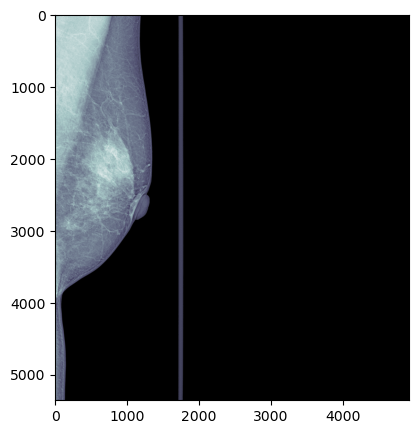

In [16]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(rescale_img_to_hu(dcm_read),cmap="bone")

In [17]:
patient_id = 10011
data_base/f"train_images/{patient_id}"

Path('../data/rsna/train_images/10011')

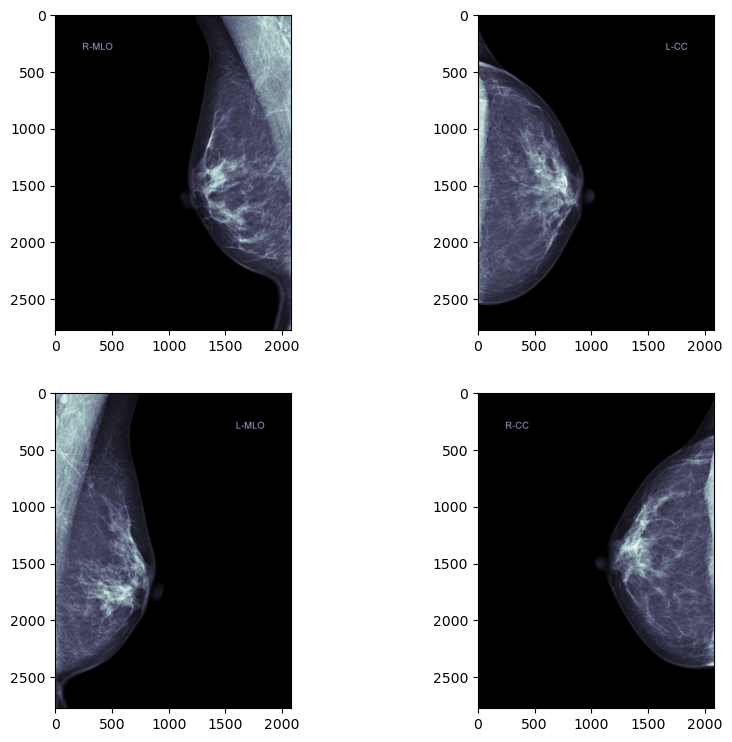

In [18]:
fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.flatten()

for i, i_path in enumerate((data_base/f"train_images/{patient_id}").iterdir()):
    ds = pydicom.dcmread(i_path)
    axs[i].imshow(rescale_img_to_hu(ds),cmap="bone")

Ok we can now plot per patient, lets quickly wrap this in a method

In [19]:
def show_images_for_patient(patient_id:int):
    fig, axs = plt.subplots(2,2,figsize=(10,9))
    axs = axs.flatten()

    for i, i_path in enumerate((data_base/f"train_images/{patient_id}").iterdir()):
        ds = pydicom.dcmread(i_path)
        axs[i].imshow(rescale_img_to_hu(ds),cmap="bone")

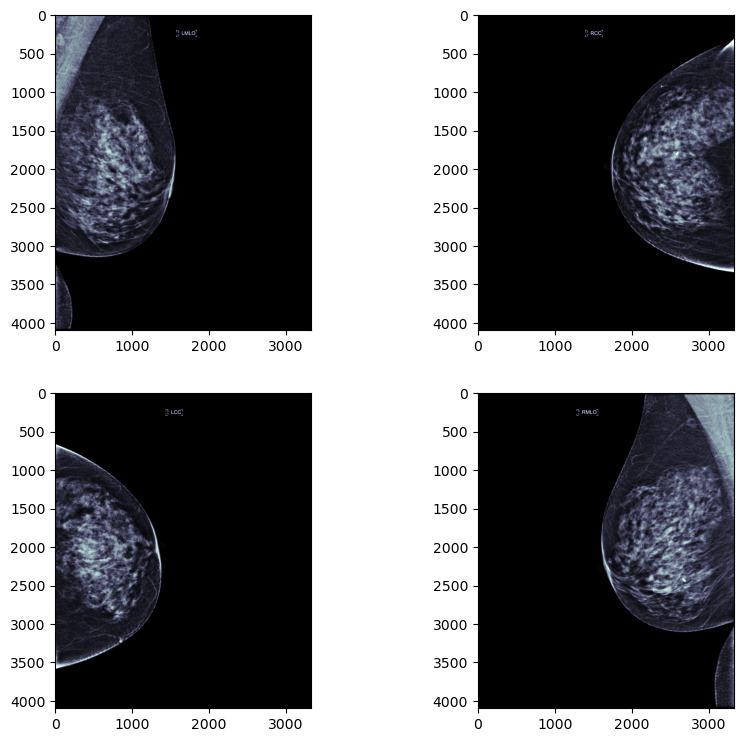

In [20]:
show_images_for_patient(3605)

Radek makes an excellent point here that most of the image is not used, which ends up being wasted compute, and that we should crop out the unused space. This is the kind of 'data science' thinking that I'm excited to learn and practice, its a totally intuitive statement but not my first thought and is obviously something that comes from experience.

In [21]:
import altair as alt
alt.themes.enable("ggplot2")

ThemeRegistry.enable('ggplot2')

In [22]:
source = train_metadata_df.cancer.value_counts().reset_index().rename(columns={"index":'Diagnosis',"cancer":"Count"}).replace({0:"No Cancer",1:"Has Cancer"})

bars = alt.Chart(source).mark_bar().encode(
    y='Count:Q',
    x='Diagnosis:O',
    color="Diagnosis"
)

text = bars.mark_text(dy=-12,align="center", color="black").encode(
    text='Count:Q',
    color="Diagnosis:O"
)



(bars + text).properties(width=600,height=400)

alt.LayerChart(...)

As he notes, we're highly imbalanced here, he's proposed upsampling of the cancer class, or downsampling of the cancer absent class. I'm guessing this is a way of making these two predictions appear more equally in the dataset but I'm not confident of that statement yet.

## Creating our DataLoaders

As usual we've got to make our data loaders object to feed into our learner object, we need to define a labelling function and a DataBlock object.

Our labelling function is simply taking image ID and then lookup in the training metadata dataframe whether that patient has cancer or not.

In [23]:
from fastai.data.all import *
from fastai.vision.all import *

Ok so this label function looks up the image ID row that matches the path.stem (filename without .dcm extension) and then gets the only value in that array. I'm sure Radek's implementation is faster, I wanted to make sure I wrote my own so that I understand the concept and what the fastai library is actually looking for in return from these labelling functions

In [24]:
def label_func(path): return train_metadata_df.loc[train_metadata_df["image_id"] == int(path.stem)]["cancer"].iloc[0];

In [25]:
# Radeks Implementation: https://www.kaggle.com/code/radek1/eda-training-a-fast-ai-model-submission?scriptVersionId=113529299&cellId=37

fn2label = {fn: cancer_or_not for fn, cancer_or_not in zip(train_metadata_df['image_id'].astype('str'), train_metadata_df['cancer'])}

def radek_label_func(path):
    return fn2label[path.stem]

In [26]:
test_path = (data_base / "train_images").ls()[0].ls()[0]

In [27]:
%%time
label_func(test_path), type(label_func(test_path))

CPU times: total: 31.2 ms
Wall time: 5 ms


(0, numpy.int64)

In [28]:
%%time
radek_label_func(test_path), type(radek_label_func(test_path))

CPU times: total: 0 ns
Wall time: 0 ns


(0, int)

Ok so mine is heaps slower, looks like its best to pre-compute these pairs and do a quicker lookup. Lets re-define my function and move one

In [29]:
lookup_dict = train_metadata_df[["image_id","cancer"]].set_index("image_id").to_dict()["cancer"]

In [30]:
def label_func(path): return lookup_dict[int(test_path.stem)]

In [31]:
%%time
label_func(test_path), type(label_func(test_path))

CPU times: total: 0 ns
Wall time: 0 ns


(0, int)

In [32]:
from fastai.medical.imaging import *
get_dicom_files(data_base/"train_images")

(#54706) [Path('../data/rsna/train_images/10006/1459541791.dcm'),Path('../data/rsna/train_images/10006/1864590858.dcm'),Path('../data/rsna/train_images/10006/1874946579.dcm'),Path('../data/rsna/train_images/10006/462822612.dcm'),Path('../data/rsna/train_images/10011/1031443799.dcm'),Path('../data/rsna/train_images/10011/220375232.dcm'),Path('../data/rsna/train_images/10011/270344397.dcm'),Path('../data/rsna/train_images/10011/541722628.dcm'),Path('../data/rsna/train_images/10025/1365269360.dcm'),Path('../data/rsna/train_images/10025/288394860.dcm')...]

Great, this looks similarly instant to Radek's, I like his use of zips and dicts. I know fastai & Jeremy are pervasive proponents of the lambda functions within Python, I owe it to myself to join the club and learn more about them.

In order to iterate quickly, I'm going to convert a sample of scans to jpegs so that I can quickly work with the images as I'm not versed in the medical imaging library of fastai.

[Once again Jeremy provides inspiration on why we should do this](https://www.kaggle.com/code/jhoward/cleaning-the-data-for-rapid-prototyping-fastai/notebook)

In [35]:
#hide
# nrm = Normalize(tensor([0.6],device=0),tensor([0.25],device=0))
# aug = aug_transforms(p_lighting=0.)
# # batch_tfms = [IntToFloatTensor(), nrm, *aug]
# # batch_tfms = [IntToFloatTensor(), nrm]
# batch_tfms = [nrm]

# dblock = DataBlock(
#     blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
#     get_items = get_dicom_files,
#     # item_tfms=[ToTensor],
#     # batch_tfms=RandomResizedCrop((512,512)),
#     get_y=label_func,
#     splitter=RandomSplitter())
# dsets = dblock.datasets(data_base/"train_images")
# dls = dblock.dataloaders(data_base/"train_images")

In [49]:
sample_dcms = get_dicom_files(data_base/"train_images")[:5000]
sample_dcms

In [ ]:
%%time

import dicom2jpg
for sample in sample_dcms:
    dicom2jpg.dicom2jpg(sample)
    
# Lets see that we've got a bunch of images now
get_images_files(data_base/"train_images")

Lets re-declare the label function as our images now have a 'Ser_' prefix that we need to get rid of

In [46]:
def label_func(path): return lookup_dict[int(test_path.stem)]

Path('../data/rsna/train_images/10006/1459541791/.jpg')

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock),
    get_items = get_image_files,
    batch_tfms=Resize(512,512),
    get_y=label_func,
    bs=32,
    splitter=RandomSplitter())
dsets = dblock.datasets(data_base/"train_images")
dls = dblock.dataloaders(data_base/"train_images")
dls.show_batch()